<a href="https://colab.research.google.com/github/nicoleolivetto/Stage-Thesis/blob/main/Tesi/covid_data_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

In [175]:
covid_ds =pd.read_csv("covid_ds.csv")
covid_ds

,Unnamed: 0,Date,Region_code,Region_name,latitude,longitude,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5
1,1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0
2,2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1
3,3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10
4,4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1717,1717,2020-05-15T17:00:00,19,Sicilia,38.115697,13.362357,198,11,209,1551,1760,-94,8,1351,263,3374,112929
1718,1718,2020-05-15T17:00:00,9,Toscana,43.769231,11.255889,238,67,305,2863,3168,-220,24,5739,976,9883,197365
1719,1719,2020-05-15T17:00:00,10,Umbria,43.106758,12.388247,25,2,27,63,90,-2,2,1259,73,1422,53801
1720,1720,2020-05-15T17:00:00,2,Valle d'Aosta,45.737503,7.320149,37,0,37,40,77,-3,6,953,142,1172,11413


Preprocessing


In [176]:
# Convert 'Date' to datetime
covid_ds['Date'] = pd.to_datetime(covid_ds['Date'])

# Normalize numeric columns
numeric_columns = ['latitude', 'longitude', 'hospitalized_with_symptoms', 'intensive_care_petients',
                    'total_hospitalized_patients', 'home_isolation', 'current_positive_cases',
                    'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases',
                    'tests_performed']


scaler = MinMaxScaler()
covid_ds[numeric_columns] = scaler.fit_transform(covid_ds[numeric_columns])

# One-hot encode 'Region_name'
covid_ds = pd.get_dummies(covid_ds, columns=['Region_name'])


In [177]:
# Print summary statistics of numeric columns after normalization
print("Summary Statistics After Normalization:")
print(covid_ds[numeric_columns].describe())

Summary Statistics After Normalization:
          latitude    longitude  hospitalized_with_symptoms  \
count  1722.000000  1722.000000                 1722.000000   
mean      0.588121     0.513847                    0.066504   
std       0.296948     0.278586                    0.151006   
min       0.000000     0.000000                    0.000000   
25%       0.359021     0.398135                    0.003726   
50%       0.656167     0.530846                    0.014118   
75%       0.873035     0.675379                    0.053552   
max       1.000000     1.000000                    1.000000   

       intensive_care_petients  total_hospitalized_patients  home_isolation  \
count              1722.000000                  1722.000000     1722.000000   
mean                  0.071085                     0.067628        0.071551   
std                   0.140784                     0.150991        0.139678   
min                   0.000000                     0.000000        0.000000 

In [178]:
print(covid_ds[numeric_columns])

      latitude  longitude  hospitalized_with_symptoms  \
0     0.505213   0.636656                    0.000000   
1     0.301036   0.888741                    0.000000   
2     0.094264   0.971409                    0.000000   
3     0.324903   0.725939                    0.000000   
4     0.760848   0.421230                    0.000828   
...        ...        ...                         ...   
1717  0.000000   0.632876                    0.016395   
1718  0.674353   0.412239                    0.019707   
1719  0.595334   0.530846                    0.002070   
1720  0.909129   0.000000                    0.003064   
1721  0.873035   0.525630                    0.025751   

      intensive_care_petients  total_hospitalized_patients  home_isolation  \
0                    0.000000                     0.000000        0.000000   
1                    0.000000                     0.000000        0.000000   
2                    0.000000                     0.000000        0.000000   
3  

In [179]:
# 'selected_regions' contains the region codes you want to learn from (Northern Italy)
selected_regions = [8, 6, 7, 3, 1, 2, 5, 21, 22]

# Select data for the autoencoder from specified regions
autoencoder_data = covid_ds[covid_ds['Region_code'].isin(selected_regions)]

# Select data for evaluation from other regions
other_regions_data = covid_ds[~covid_ds['Region_code'].isin(selected_regions)]

# Columns relevant for the autoencoder
autoencoder_columns = ['hospitalized_with_symptoms', 'intensive_care_petients', 'total_hospitalized_patients', 'home_isolation', 'current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases', 'tests_performed']

# Extract the relevant columns for training and evaluation
train_data = autoencoder_data[autoencoder_columns].values
test_data = other_regions_data[autoencoder_columns].values

# Print the shapes of the training and test sets
print("Train Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


Train Data Shape: (738, 11)
Test Data Shape: (984, 11)


In [180]:

input_shape = train_data.shape[1]

# Define the autoencoder model
model = models.Sequential()

# Encoder
model.add(layers.InputLayer(input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Decoder
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(input_shape, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Print the model summary
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                768       
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dense_22 (Dense)            (None, 64)                2112      
                                                                 
 dense_23 (Dense)            (None, 11)                715       
                                                                 
Total params: 5675 (22.17 KB)
Trainable params: 5675 (22.17 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
# Train the model
model.fit(train_data, train_data, epochs=100, batch_size=128, validation_data=(test_data, test_data))


Epoch 1/100
6/6 [==============================] - 1s 33ms/step - loss: 0.3999 - val_loss: 0.4451
Epoch 2/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3901 - val_loss: 0.4344
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3789 - val_loss: 0.4204
Epoch 4/100
6/6 [==============================] - 0s 11ms/step - loss: 0.3641 - val_loss: 0.4020
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 0.3445 - val_loss: 0.3766
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 0.3186 - val_loss: 0.3418
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2848 - val_loss: 0.2959
Epoch 8/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2438 - val_loss: 0.2385
Epoch 9/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1976 - val_loss: 0.1754
Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1527 - val_loss: 0.1228
Epoch 11/100
6/6 [====

31/31 [==============================] - 0s 1ms/step
984


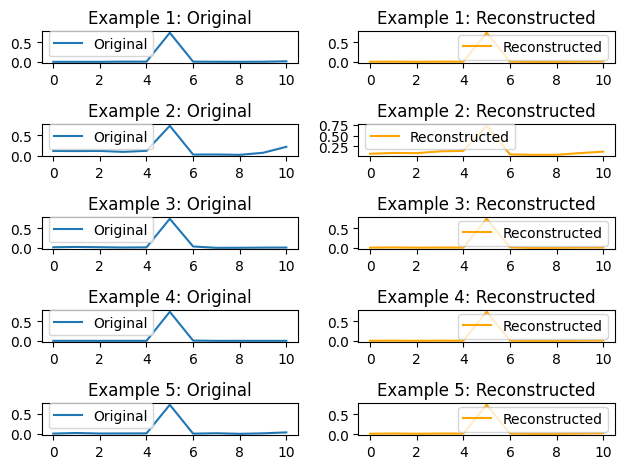

In [182]:
import matplotlib.pyplot as plt

# Predict on test data
reconstructed_data = model.predict(test_data)

print(len(reconstructed_data))

# Choose a few random examples for visualization
num_examples = 5
examples_indices = np.random.choice(len(test_data), num_examples, replace=False)

# Plot original and reconstructed data
for i, example_index in enumerate(examples_indices, 1):
    plt.subplot(num_examples, 2, 2 * i - 1)
    plt.plot(test_data[example_index], label='Original')
    plt.title(f'Example {i}: Original')
    plt.legend()

    plt.subplot(num_examples, 2, 2 * i)
    plt.plot(reconstructed_data[example_index], label='Reconstructed', color='orange')
    plt.title(f'Example {i}: Reconstructed')
    plt.legend()

plt.tight_layout()
plt.show()

In [183]:
print(test_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.08421980e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.81684396e-06]
 ...
 [1.63948000e-02 7.96524258e-03 1.56812725e-02 ... 1.70657323e-02
  4.01098444e-02 2.05174372e-01]
 [1.97068808e-02 4.85155684e-02 2.28841537e-02 ... 6.33313867e-02
  1.17488320e-01 3.58581408e-01]
 [2.07005051e-03 1.44822592e-03 2.02581032e-03 ... 4.73687626e-03
  1.69046232e-02 9.77480219e-02]]


In [184]:
print(reconstructed_data)

[[0.00483204 0.00704114 0.00399502 ... 0.00369863 0.00776068 0.00980057]
 [0.00483198 0.00704106 0.00399494 ... 0.00369846 0.00776032 0.00979983]
 [0.00483199 0.00704107 0.00399495 ... 0.00369849 0.00776039 0.00979997]
 ...
 [0.01895317 0.02565241 0.01933724 ... 0.02540158 0.04824516 0.13480754]
 [0.03375547 0.03967726 0.03728885 ... 0.0523518  0.10590597 0.36293334]
 [0.00736564 0.01145516 0.00676868 ... 0.00822137 0.01673602 0.03475578]]


In [185]:
print("Train Data Shape:", test_data.shape)
print("Reconstructed Data Shape:", reconstructed_data.shape)

Train Data Shape: (984, 11)
Reconstructed Data Shape: (984, 11)


In [186]:
# Calculate reconstruction errors for each feature
mae = np.mean(np.abs(test_data - reconstructed_data), axis=0)


In [187]:
# Print the MAE for each feature
print("Mean Absolute Error (MAE) for Each Feature:")
for i, mae_value in enumerate(mae):
    print(f"Feature {i}: {mae_value}")

Mean Absolute Error (MAE) for Each Feature:
Feature 0: 0.006827015362847057
Feature 1: 0.010847883719085911
Feature 2: 0.006279413702791889
Feature 3: 0.009893019853829317
Feature 4: 0.0077902925781589425
Feature 5: 0.003126453487072798
Feature 6: 0.009083888596023515
Feature 7: 0.007049654459013926
Feature 8: 0.006457878763976976
Feature 9: 0.005699754836598107
Feature 10: 0.01835648027948463


In [188]:
# Calculate the nth percentile of MAE values
threshold = np.percentile(mae, 80)

# Identify features with MAE values exceeding the threshold
difficult_features = [i for i, mae_value in enumerate(mae) if mae_value > threshold]


print("Features with MAE exceeding the threshold:")
for feature_index in difficult_features:
    print(f"Feature {feature_index}: MAE = {mae[feature_index]}")

Features with MAE exceeding the threshold:
Feature 1: MAE = 0.010847883719085911
Feature 10: MAE = 0.01835648027948463


In [189]:
column_names = autoencoder_columns

# Print the MAE for each feature along with the corresponding column name
print("Mean Absolute Error (MAE) for Each Feature:")
for i, mae_value in enumerate(mae):
    feature_name = column_names[i]
    print(f"{feature_name}: {mae_value}")

Mean Absolute Error (MAE) for Each Feature:
hospitalized_with_symptoms: 0.006827015362847057
intensive_care_petients: 0.010847883719085911
total_hospitalized_patients: 0.006279413702791889
home_isolation: 0.009893019853829317
current_positive_cases: 0.0077902925781589425
change_in_total_positives: 0.003126453487072798
new_positive_cases: 0.009083888596023515
recovered: 0.007049654459013926
deceased: 0.006457878763976976
total_cases: 0.005699754836598107
tests_performed: 0.01835648027948463


Mean Absolute Error (MAE) for Each Feature:


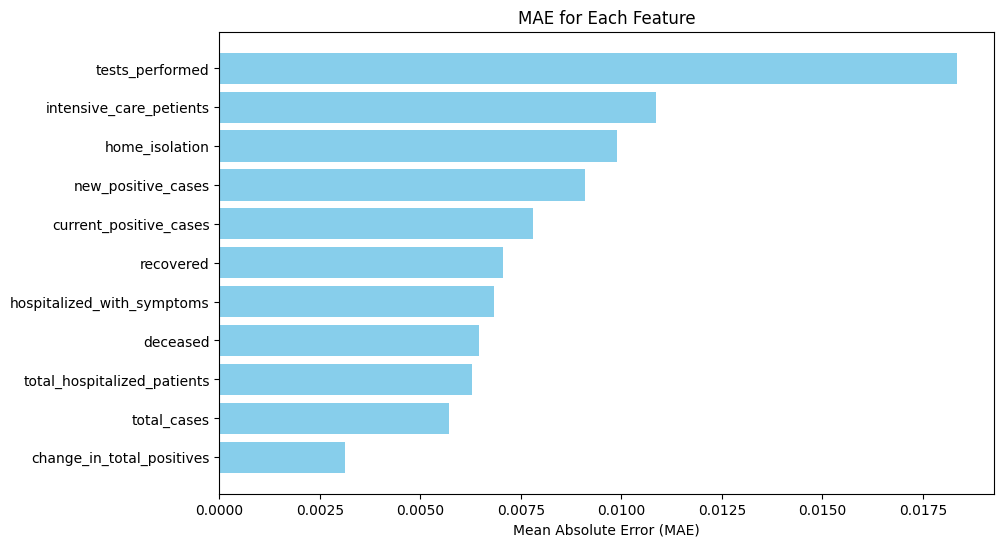

In [190]:

print("Mean Absolute Error (MAE) for Each Feature:")
mae_feature_pairs = [(mae_value, feature_name) for mae_value, feature_name in zip(mae, column_names)]

# Sort the MAE-feature pairs by MAE values
mae_feature_pairs.sort()


sorted_mae, sorted_features = zip(*mae_feature_pairs)

plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_mae, color='skyblue')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('MAE for Each Feature')
plt.show()

In [191]:
print(reconstructed_data)

[[0.00483204 0.00704114 0.00399502 ... 0.00369863 0.00776068 0.00980057]
 [0.00483198 0.00704106 0.00399494 ... 0.00369846 0.00776032 0.00979983]
 [0.00483199 0.00704107 0.00399495 ... 0.00369849 0.00776039 0.00979997]
 ...
 [0.01895317 0.02565241 0.01933724 ... 0.02540158 0.04824516 0.13480754]
 [0.03375547 0.03967726 0.03728885 ... 0.0523518  0.10590597 0.36293334]
 [0.00736564 0.01145516 0.00676868 ... 0.00822137 0.01673602 0.03475578]]


In [192]:
reconstructed_df = pd.DataFrame(reconstructed_data, columns=autoencoder_columns)
reconstructed_df

,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0.004832,0.007041,0.003995,0.006875,0.006103,0.734115,0.008395,0.002823,0.003699,0.007761,0.009801
1,0.004832,0.007041,0.003995,0.006875,0.006102,0.734116,0.008396,0.002822,0.003698,0.007760,0.009800
2,0.004832,0.007041,0.003995,0.006875,0.006102,0.734115,0.008396,0.002822,0.003698,0.007760,0.009800
3,0.004832,0.007041,0.003995,0.006875,0.006103,0.734114,0.008395,0.002823,0.003699,0.007761,0.009801
4,0.004901,0.007141,0.004057,0.006938,0.006170,0.734238,0.008507,0.002844,0.003728,0.007814,0.009832
...,...,...,...,...,...,...,...,...,...,...,...
979,0.022798,0.030731,0.023756,0.043829,0.046184,0.730530,0.019455,0.031948,0.027688,0.049811,0.114340
980,0.008506,0.012940,0.007887,0.013698,0.013731,0.728761,0.011136,0.007925,0.008447,0.016629,0.028911
981,0.018953,0.025652,0.019337,0.038532,0.040849,0.730144,0.015657,0.032705,0.025402,0.048245,0.134808
982,0.033755,0.039677,0.037289,0.085859,0.086747,0.710848,0.022418,0.090973,0.052352,0.105906,0.362933


In [193]:
test_data_df = pd.DataFrame(test_data, columns=autoencoder_columns)
test_data_df

,hospitalized_with_symptoms,intensive_care_petients,total_hospitalized_patients,home_isolation,current_positive_cases,change_in_total_positives,new_positive_cases,recovered,deceased,total_cases,tests_performed
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000009
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000002
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.732474,0.005506,0.000000,0.000000,0.000000,0.000018
4,0.000083,0.000724,0.000150,0.000000,0.000054,0.732474,0.006118,0.000024,0.000000,0.000036,0.000225
...,...,...,...,...,...,...,...,...,...,...,...
979,0.023599,0.016655,0.023109,0.061648,0.058461,0.722596,0.008259,0.042088,0.029914,0.051903,0.159314
980,0.006210,0.007241,0.006378,0.012376,0.012357,0.731925,0.006424,0.018603,0.008111,0.016025,0.072390
981,0.016395,0.007965,0.015681,0.051050,0.047176,0.719577,0.007954,0.032982,0.017066,0.040110,0.205174
982,0.019707,0.048516,0.022884,0.094233,0.084917,0.702291,0.012848,0.140105,0.063331,0.117488,0.358581


In [194]:
print(covid_ds.Date)
print(covid_ds.Region_code)

0      2020-02-24 18:00:00
1      2020-02-24 18:00:00
2      2020-02-24 18:00:00
3      2020-02-24 18:00:00
4      2020-02-24 18:00:00
               ...        
1717   2020-05-15 17:00:00
1718   2020-05-15 17:00:00
1719   2020-05-15 17:00:00
1720   2020-05-15 17:00:00
1721   2020-05-15 17:00:00
Name: Date, Length: 1722, dtype: datetime64[ns]
0       13
1       17
2       18
3       15
4        8
        ..
1717    19
1718     9
1719    10
1720     2
1721     5
Name: Region_code, Length: 1722, dtype: int64


In [195]:
daily_differences = np.abs(test_data - reconstructed_data)

mean_daily_difference = np.mean(daily_differences, axis=0)

print("Mean Difference for Each Feature:")
for i, mean_diff_value in enumerate(mean_daily_difference):
    print(f"Feature {i}: {mean_diff_value}")

# Calculate the threshold as a percentile of mean differences
threshold = np.percentile(mean_daily_difference, 80)

# Identify features with mean differences exceeding the threshold
difficult_features = [i for i, mean_diff_value in enumerate(mean_daily_difference) if mean_diff_value > threshold]

print("Features with Mean Difference exceeding the threshold:")
for feature_index in difficult_features:
    print(f"Feature {feature_index}: Mean Diff = {mean_daily_difference[feature_index]}")

total_differences = np.sum(daily_differences, axis=0)

# Display the results in a DataFrame
result_df = pd.DataFrame({
    'Feature': autoencoder_columns,
    'Mean_Difference': mean_daily_difference,
    'Total_Difference': total_differences
})

print(result_df)


Mean Difference for Each Feature:
Feature 0: 0.006827015362847057
Feature 1: 0.010847883719085911
Feature 2: 0.006279413702791889
Feature 3: 0.009893019853829317
Feature 4: 0.0077902925781589425
Feature 5: 0.003126453487072798
Feature 6: 0.009083888596023515
Feature 7: 0.007049654459013926
Feature 8: 0.006457878763976976
Feature 9: 0.005699754836598107
Feature 10: 0.01835648027948463
Features with Mean Difference exceeding the threshold:
Feature 1: Mean Diff = 0.010847883719085911
Feature 10: Mean Diff = 0.01835648027948463
                        Feature  Mean_Difference  Total_Difference
0    hospitalized_with_symptoms         0.006827          6.717783
1       intensive_care_petients         0.010848         10.674318
2   total_hospitalized_patients         0.006279          6.178943
3                home_isolation         0.009893          9.734732
4        current_positive_cases         0.007790          7.665648
5     change_in_total_positives         0.003126          3.076430
6

In [196]:
daily_differences = np.abs(test_data - reconstructed_data)

percentile_threshold = 95

threshold = np.percentile(daily_differences, percentile_threshold)

# Count the number of values exceeding the threshold for each column
values_exceeding_threshold = np.sum(daily_differences > threshold, axis=0)

print(f"Number of Values Exceeding {percentile_threshold}th Percentile Threshold for Each Column:")
for i, count in enumerate(values_exceeding_threshold):
    print(f"Column {i}: {count} values exceed the threshold")

total_differences = np.sum(daily_differences, axis=0)

result_df = pd.DataFrame({
    'Feature': autoencoder_columns,
    'Total_Difference': total_differences
})

print(result_df)


Number of Values Exceeding 95th Percentile Threshold for Each Column:
Column 0: 28 values exceed the threshold
Column 1: 80 values exceed the threshold
Column 2: 22 values exceed the threshold
Column 3: 64 values exceed the threshold
Column 4: 7 values exceed the threshold
Column 5: 5 values exceed the threshold
Column 6: 78 values exceed the threshold
Column 7: 13 values exceed the threshold
Column 8: 24 values exceed the threshold
Column 9: 1 values exceed the threshold
Column 10: 220 values exceed the threshold
                        Feature  Total_Difference
0    hospitalized_with_symptoms          6.717783
1       intensive_care_petients         10.674318
2   total_hospitalized_patients          6.178943
3                home_isolation          9.734732
4        current_positive_cases          7.665648
5     change_in_total_positives          3.076430
6            new_positive_cases          8.938546
7                     recovered          6.936860
8                      decease

In [197]:
print(test_data)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.08421980e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.81684396e-06]
 ...
 [1.63948000e-02 7.96524258e-03 1.56812725e-02 ... 1.70657323e-02
  4.01098444e-02 2.05174372e-01]
 [1.97068808e-02 4.85155684e-02 2.28841537e-02 ... 6.33313867e-02
  1.17488320e-01 3.58581408e-01]
 [2.07005051e-03 1.44822592e-03 2.02581032e-03 ... 4.73687626e-03
  1.69046232e-02 9.77480219e-02]]


In [198]:
# Extract the region codes for the regions in test_data
test_region_codes = other_regions_data['Region_code'].values

# Find the indexes of these region codes in the original dataset
original_indexes = covid_ds[covid_ds['Region_code'].isin(test_region_codes)].index

# Print the original indexes
print("Original Indexes of Test Regions:", original_indexes)


Original Indexes of Test Regions: Int64Index([   0,    1,    2,    3,    6,    9,   10,   14,   15,   16,
            ...
            1703, 1704, 1707, 1710, 1711, 1715, 1716, 1717, 1718, 1719],
           dtype='int64', length=984)


In [199]:
# Create datasets with Date and Region_code values added
test_data_with_dates = other_regions_data.loc[other_regions_data.index.isin(original_indexes), autoencoder_columns + ['Date', 'Region_code']].copy()
reconstructed_data_with_dates = pd.DataFrame(reconstructed_data, columns=autoencoder_columns)

print(len(reconstructed_data_with_dates))

# Add Date values to the datasets using the original indexes
test_data_with_dates['Date'] = covid_ds.loc[original_indexes, 'Date'].values
reconstructed_data_with_dates['Date'] = covid_ds.loc[original_indexes, 'Date'].values

# Add Region_code values to the datasets using the original indexes
test_data_with_dates['Region_code'] = covid_ds.loc[original_indexes, 'Region_code'].values
reconstructed_data_with_dates['Region_code'] = covid_ds.loc[original_indexes, 'Region_code'].values

print("Test Data with Dates and Region_code:")
print(test_data_with_dates)

print("\nReconstructed Data with Dates and Region_code:")
print(reconstructed_data_with_dates)


984
Test Data with Dates and Region_code:
      hospitalized_with_symptoms  intensive_care_petients  \
0                       0.000000                 0.000000   
1                       0.000000                 0.000000   
2                       0.000000                 0.000000   
3                       0.000000                 0.000000   
6                       0.000083                 0.000724   
...                          ...                      ...   
1715                    0.023599                 0.016655   
1716                    0.006210                 0.007241   
1717                    0.016395                 0.007965   
1718                    0.019707                 0.048516   
1719                    0.002070                 0.001448   

      total_hospitalized_patients  home_isolation  current_positive_cases  \
0                        0.000000        0.000000                0.000000   
1                        0.000000        0.000000                0.0000

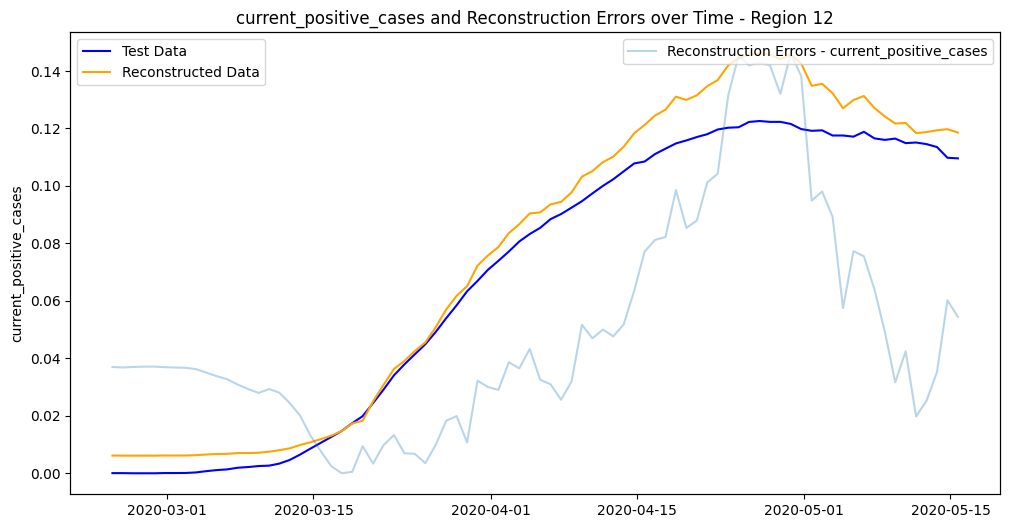

In [200]:
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases']

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot original and reconstructed data
ax1.plot(test_data_region['Date'], test_data_region[columns_to_plot[0]], label='Test Data', linestyle='-', color='blue')
ax1.plot(reconstructed_data_region['Date'], reconstructed_data_region[columns_to_plot[0]], label='Reconstructed Data', linestyle='-', color='orange')
ax1.set_ylabel(columns_to_plot[0])
ax1.legend(loc='upper left')

# Calculate reconstruction errors for each date
reconstruction_errors = np.abs(test_data_region[columns_to_plot[0]].values - reconstructed_data_region[columns_to_plot[0]].values)

ax2 = ax1.twinx()
ax2.plot(test_data_region['Date'], reconstruction_errors, label=f'Reconstruction Errors - {columns_to_plot[0]}', linestyle='-', alpha=0.3)
ax2.set_yticks([])
ax2.legend(loc='upper right')

plt.title(f'{columns_to_plot[0]} and Reconstruction Errors over Time - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.show()


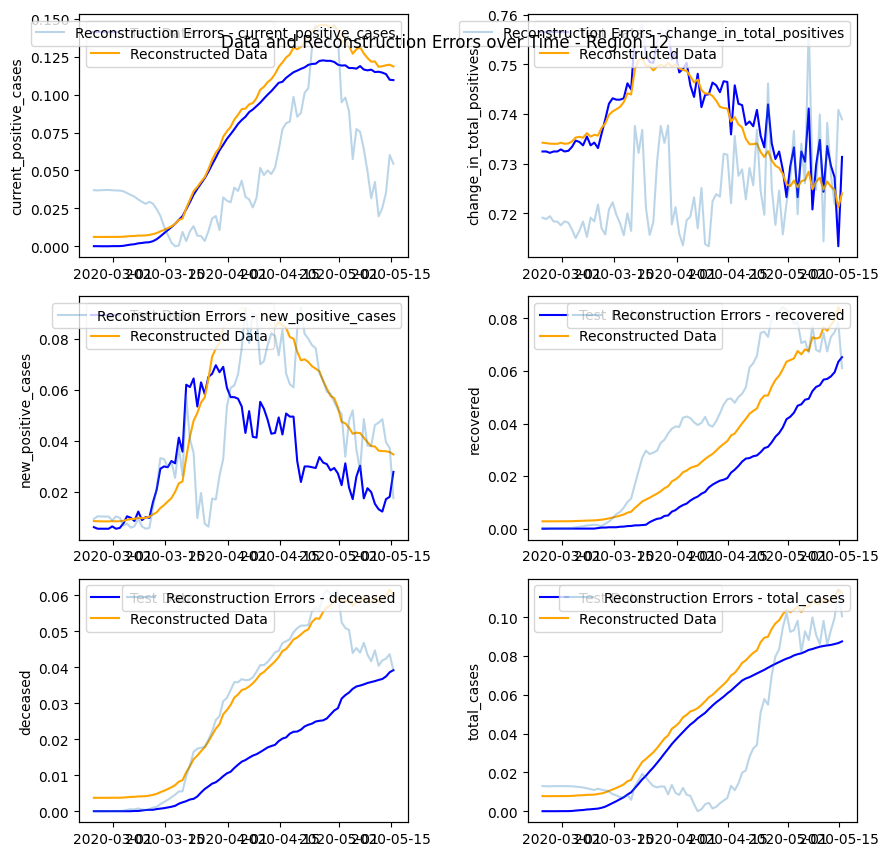

In [201]:
import matplotlib.dates as mdates
# Choose the region code to focus on
region_code_to_plot = 12

# Filter the datasets for the specific region
test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the columns to plot
columns_to_plot = ['current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])
    ax2.legend(loc='upper right')

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


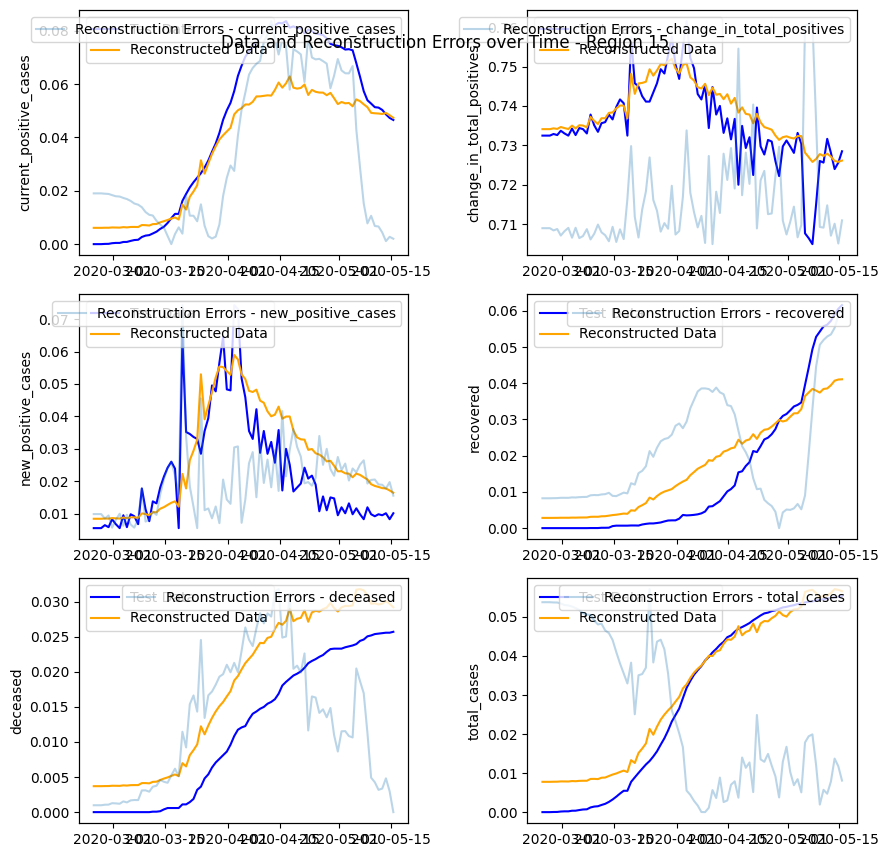

In [202]:

region_code_to_plot = 15

test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

columns_to_plot = ['current_positive_cases', 'change_in_total_positives', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])
    ax2.legend(loc='upper right')

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


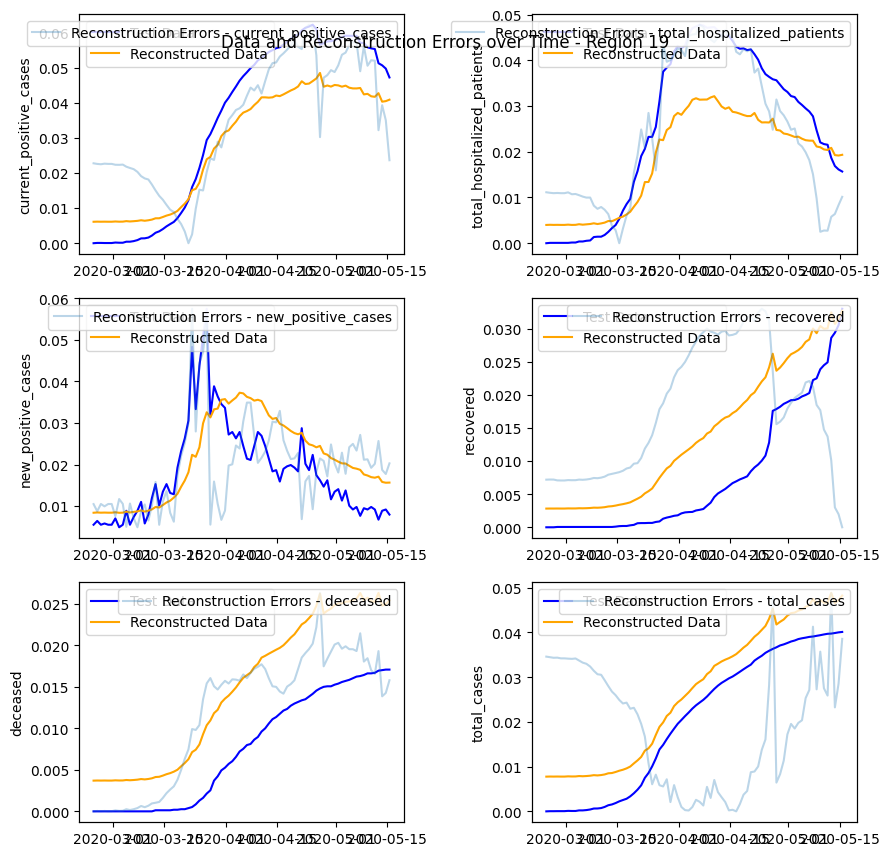

In [208]:
region_code_to_plot = 19

test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

columns_to_plot = ['current_positive_cases', 'total_hospitalized_patients', 'new_positive_cases', 'recovered', 'deceased', 'total_cases']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(9, 9))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):

    axes[i].plot(test_data_region['Date'], test_data_region[column], label='Test Data', linestyle='-', color='blue')
    axes[i].plot(reconstructed_data_region['Date'], reconstructed_data_region[column], label='Reconstructed Data', linestyle='-', color='orange')
    axes[i].set_ylabel(column)
    axes[i].legend(loc='upper left')

    reconstruction_errors = np.abs(test_data_region[column].values - reconstructed_data_region[column].values)

    ax2 = axes[i].twinx()
    ax2.plot(mdates.date2num(test_data_region['Date']), reconstruction_errors, label=f'Reconstruction Errors - {column}', linestyle='-', alpha=0.3)
    ax2.set_yticks([])
    ax2.legend(loc='upper right')

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle(f'Data and Reconstruction Errors over Time - Region {region_code_to_plot}', y=0.92)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


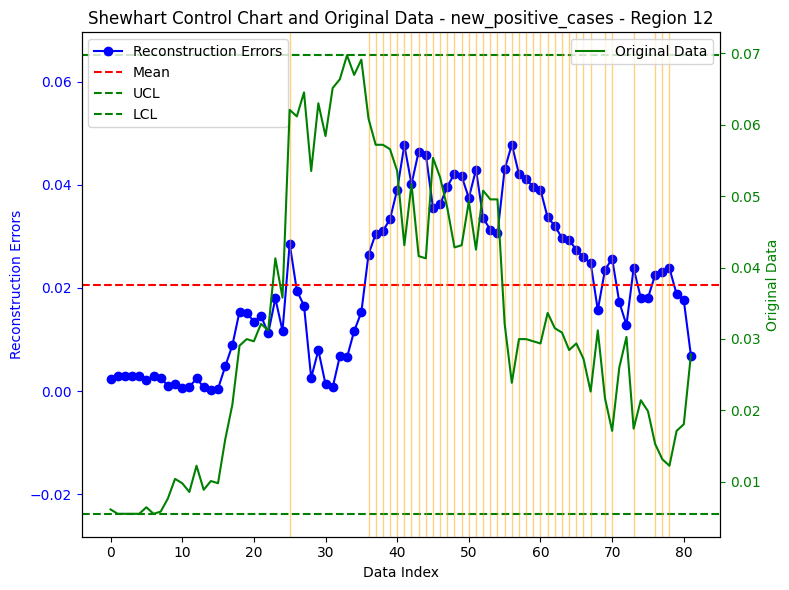

In [205]:
#LAZIO

region_code_to_plot = 12

test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

# Specify the column to plot
column_to_plot = 'new_positive_cases'

# Calculate reconstruction errors for the specific column
reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

# Calculate mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error


original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)  # Points above mean but within UCL in orange

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


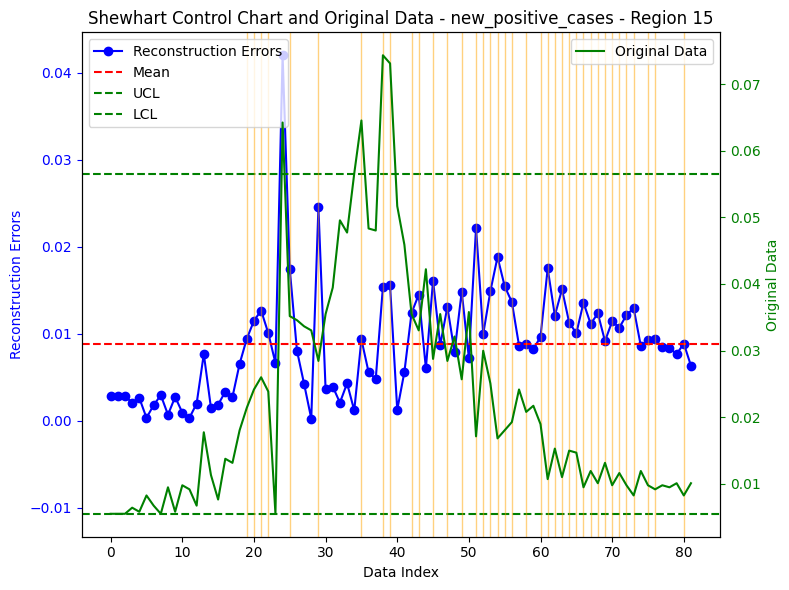

In [206]:
#CAMPANIA
region_code_to_plot = 15

test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

column_to_plot = 'new_positive_cases'

reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error

original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


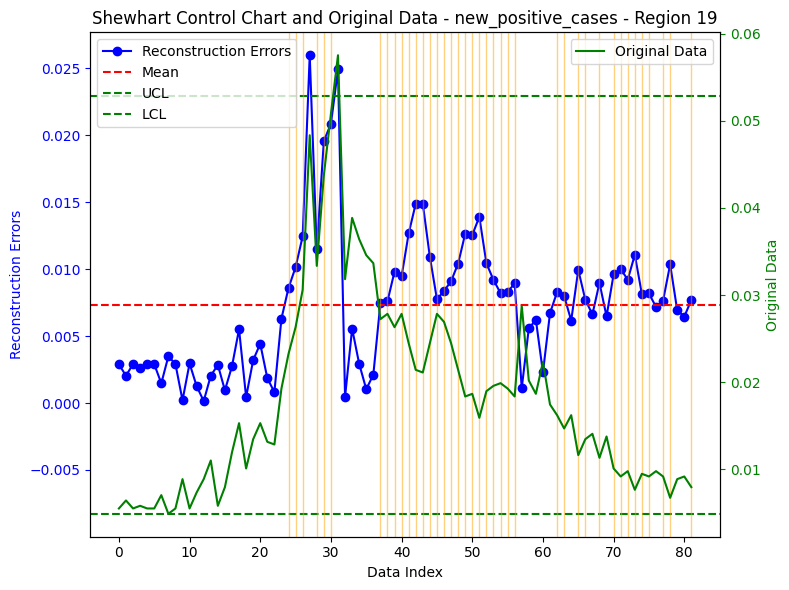

In [207]:
#SICILIA

region_code_to_plot = 19

test_data_region = test_data_with_dates[test_data_with_dates['Region_code'] == region_code_to_plot]
reconstructed_data_region = reconstructed_data_with_dates[reconstructed_data_with_dates['Region_code'] == region_code_to_plot]

column_to_plot = 'new_positive_cases'

reconstruction_errors = np.abs(test_data_region[column_to_plot].values - reconstructed_data_region[column_to_plot].values)

# Calculate mean and standard deviation of reconstruction errors
mean_error = np.mean(reconstruction_errors)
std_error = np.std(reconstruction_errors)

# Set control limits
UCL = mean_error + 3 * std_error
LCL = mean_error - 3 * std_error


original_data = test_data_region['new_positive_cases'].values

# Create a Shewhart Control Chart with vertical lines and original data
fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(len(reconstruction_errors)), reconstruction_errors, linestyle='-', marker='o', color='blue', label='Reconstruction Errors')
ax1.axhline(y=mean_error, color='red', linestyle='--', label='Mean')
ax1.axhline(y=UCL, color='green', linestyle='--', label='UCL')
ax1.axhline(y=LCL, color='green', linestyle='--', label='LCL')

# Highlight points above the mean with a different color
for i, error in enumerate(reconstruction_errors):
    if error > mean_error and error <= UCL:
        ax1.axvline(x=i, color='orange', linestyle='-', linewidth=1, alpha=0.5)

ax1.set_xlabel('Data Index')
ax1.set_ylabel('Reconstruction Errors', color='blue')
ax1.tick_params('y', colors='blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(range(len(original_data)), original_data, linestyle='-', color='green', label='Original Data')
ax2.set_ylabel('Original Data', color='green')
ax2.tick_params('y', colors='green')
ax2.legend(loc='upper right')

plt.title(f'Shewhart Control Chart and Original Data - {column_to_plot} - Region {region_code_to_plot}')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
